In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import random

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
char_set = ['.'] + sorted(list(set([ch for word in words for ch in list(word)])))
print("char set: ", char_set)
stoi = {char: i for i, char in enumerate(char_set)}  #encode(s)
itos = {i: char for i, char in enumerate(char_set)}
print("encoder: ", stoi)
print("decoder: ", itos)

vocab_size = len(itos)
print(vocab_size)

char set:  ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
encoder:  {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
decoder:  {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:
        pad_word = '.' * block_size + w + '.'
        for i in range(block_size, len(pad_word)):
            # print(pad_word[i-block_size:i], " --> ", pad_word[i])
            X.append([stoi[s] for s in pad_word[i-block_size:i]])
            Y.append(stoi[pad_word[i]])            
    return torch.tensor(X), torch.tensor(Y)


build_dataset(words[:3])


(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [ 0,  0,  0],
         [ 0,  0, 15],
         [ 0, 15, 12],
         [15, 12,  9],
         [12,  9, 22],
         [ 9, 22,  9],
         [22,  9,  1],
         [ 0,  0,  0],
         [ 0,  0,  1],
         [ 0,  1, 22],
         [ 1, 22,  1]]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0]))

In [5]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),   generator=g)               # [27, 10]
# W1 = torch.randn((block_size * n_embd, n_hidden),    generator=g)  #[3*10, 200]
# b1 = torch.randn(n_hidden,               generator=g)
# W1 = torch.randn((block_size * n_embd, n_hidden),    generator=g) * 0.2
# b1 = torch.randn(n_hidden,               generator=g) * 0.01
W1 = torch.randn((block_size * n_embd, n_hidden),    generator=g)* (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,               generator=g) * 0.01

# W2 = torch.randn((n_hidden, vocab_size), generator=g)
# b2 = torch.randn(vocab_size,             generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size,             generator=g) * 0

parameters = [C, W1, W2, b2]  #, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)  #Xtr[ix] Ytr[ix]
    xb = Xtr[ix]
    yb = Ytr[ix]
    embd = C[xb]  #[32, 3, 10]
    hpre = embd.view(-1, block_size*n_embd) @ W1 + b1  #[32, 30] -> [32, 200]
    # hpre_mean = hpre.mean(
    
    h = torch.tanh(hpre)
    logits = h @ W2 + b2  #[32, 200] -> [200, 27]
    loss = F.cross_entropy(logits, yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:     
        p.data += -lr * p.grad

      # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

    # break
    

      0/ 200000: 3.3179
  10000/ 200000: 2.1928
  20000/ 200000: 2.3333
  30000/ 200000: 2.5376
  40000/ 200000: 1.9618
  50000/ 200000: 2.3344
  60000/ 200000: 2.3849
  70000/ 200000: 2.1605
  80000/ 200000: 2.3181
  90000/ 200000: 2.2200
 100000/ 200000: 1.8285
 110000/ 200000: 2.1300
 120000/ 200000: 1.9468
 130000/ 200000: 2.3329
 140000/ 200000: 2.1031
 150000/ 200000: 2.1707
 160000/ 200000: 1.7700
 170000/ 200000: 1.7840
 180000/ 200000: 1.9529
 190000/ 200000: 1.8062


In [8]:
@torch.no_grad() # this decorator disables gradient tracking for this function
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  # #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.03947377204895
val 2.109386444091797


In [9]:
# Problem 1: fix softmax confidently wrong:

# original   "hockey stick" plot
# 0/ 200000: 25.9595    # here logits starts with quite large values,  we wanna logits to be small and close
# 10000/ 200000: 2.7178
# 180000/ 200000: 2.2081
# 190000/ 200000: 1.8474

# train 2.1246278285980225
# val 2.162187099456787

# to fix: 
# W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
# b2 = torch.randn(vocab_size,             generator=g) * 0   #last layer, b2 not needed

# Problem 2,  fix tanh layer too saturated at init:

# large pre-activation value land on the tail of activate function (sigmoid, tanh, relu), thus has grad = 0 when backprop from loss (have no effect on loss)
# plt.hist(h.view(-1).tolist(), 50) # many h are either -1 or 1, as a result, the grad of tanh is nearly zero
# plt.hist(hpre.view(-1).tolist(), 50)  # range -20 to 20
# plt.figure(figsize = (20, 10))
# plt.imshow(h.abs() >0.99, cmap='gray', interpolation='nearest') # white if true >0.99  32 examples, 200 neuron, any column with all white become dead neuron

# to fix
# b1 *= 0.01
# w1 *= 0.2

# train 2.0355184078216553
# val 2.1053760051727295

# it's important to initializw weight correctly, 
#use semi-principled "kaiming init" (most popular): 
#orig: W1 = torch.randn((block_size * n_embd, n_hidden) has N(mean =0, std =1)
# kaiming gain for tanh = 5/3, std = gain/sqrt("fan_mode"= "fan-in" (default)) in our case fan-in = 30 = block_size * n_embd 
# so W1 will be initiliazed to N(0, std^2) of above std
# train 2.0378851890563965
# val 2.102691650390625

# Batch Normalization : directly fix Problem 2,  fix tanh layer too saturated at init  , normalize pre-activate h
# hpre.shape  # torch.Size([32, 200])  200 neurons, make normal across batch, mean and std taken vertically
# hpre.mean(0, keepdim=True).shape  #torch.Size([1, 200])
(hpre - hpre.mean(0, keepdim=True)) / hpre.std(0, keepdim=True)  # torch.Size([32, 200]) step1: standardize
# however, we'd like this distribution to move and backprop will tell us how to   
# step 2: scale and shift: scale by some gain and offseting by some shift:  bngain * above + bnbias
# initialize
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# so its customary to add normalization after we have a linear layer ( matrix multiplication) and before doing activation

In [10]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),   generator=g)               # [27, 10]
W1 = torch.randn((block_size * n_embd, n_hidden),    generator=g)* (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,               generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size,             generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))


bnmean_running = torch.zeros((1, n_hidden)) # for each hidden neuron there's mean across batch i (bnmeani), bnmean_running := mean across all batches
bnstd_running = torch.ones((1, n_hidden)) # these two are stats from data, not parameters


parameters = [C, W1, W2, b2, bngain, bnbias]  #, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [11]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)  #Xtr[ix] Ytr[ix]
    xb = Xtr[ix]
    yb = Ytr[ix]
    embd = C[xb]  #[32, 3, 10]
    # Linear layer
    hpre = embd.view(-1, block_size*n_embd) @ W1 # + b1  Note: b1 is wasted here since later we take average, instead we introduce bnbias for shifts
    # BatchNorm layer
    bnmeani = hpre.mean(0, keepdim=True)
    bnstdi = hpre.std(0, keepdim=True)
    hpre = bngain*(hpre - bnmeani)/bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani  # momentum: 0.001, for larger batch size, these stats more stable, can use larger momentum like 0.1
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpre)
    logits = h @ W2 + b2  #[32, 200] -> [200, 27]
    loss = F.cross_entropy(logits, yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:     
        p.data += -lr * p.grad

      # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [12]:
# Verify that bnmean_running is close to bnmean across all batches

# calibrate the batch norm at the end of training
with torch.no_grad():
    # bnmean ans bnstd over entire training set ( not estimate)
    embd = C[Xtr]  
    # Linear layer
    hpre = embd.view(-1, block_size*n_embd) @ W1 + b1  #[32, 30] -> [32, 200]
    # BatchNorm layer
    bnmean = hpre.mean(0, keepdim=True)
    bnstd = hpre.std(0, keepdim=True)

print(bnmean)
# estimate bnmean and bnstd during runnning 
print(bnmean_running)

print(bnstd)
# estimate bnmean and bnstd during runnning 
print(bnstd_running)

tensor([[-2.3355,  0.6776, -0.9133,  1.0163,  1.0865,  1.0938,  1.7437, -2.1208,
          0.5730,  1.4455, -1.6344, -2.7372, -0.4752, -0.1412, -0.0745, -1.1722,
          0.6851, -2.6219, -0.1065,  1.6326, -0.7706, -0.3063,  0.0479,  0.6115,
          1.1173,  0.2427,  2.0500,  0.5831,  0.8527,  1.7680, -0.3625, -0.8355,
         -0.0854, -0.5177, -0.3806, -1.0699, -0.0786,  0.3487, -0.5808,  0.9875,
         -0.4427, -1.3082, -0.2871, -0.2332,  0.6850,  0.6850,  2.0857, -0.7608,
          2.3866,  1.8734,  0.8259,  0.2803,  1.8897,  0.4709,  0.6739, -1.8940,
         -0.0401,  0.4338,  1.3760, -0.8910, -0.4524,  1.1754,  0.5613,  0.6051,
          1.5859,  1.2261, -1.0111,  2.1495, -0.6393,  0.0938, -0.2864, -0.4856,
          0.9632, -1.0461, -2.9990,  0.6391,  1.4327, -0.1590,  0.0941,  0.5253,
          0.2508,  1.2521,  2.0388,  0.6608,  0.0692, -0.0813, -1.6723,  0.2933,
          2.2423, -0.0210, -0.6666,  1.4253, -0.8411, -1.2248, -1.0129,  0.2230,
          0.2113, -0.3226,  

In [13]:
@torch.no_grad() # this decorator disables gradient tracking for this function
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066636800765991
val 2.105013132095337


In [14]:
#------------------------  PyTorchify it ------------------------------
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

# fill-in each init, call, parameters

class Tanh: 
    # __ini__  is not required 
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


class Embedding:
    def __init__(self, vocab_size, embd_dim):
        self.embd = torch.randn((vocab_size, embd_dim), generator=g)  # build a row vector for each vocab

    def __call__(self, x): # x.shape [#samples, block_size] where each row contains index of vocab for n_context long e.g. [4,1,376]
        #out = embd[x]   # return shape should [#samples, block_size, embd_dim]
        self.out = self.embd[x].view(x.shape[0], -1)   # must be self.out!
        return self.out
        
    def parameters(self):
        return [self.embd]

class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        # self.weights = torch.randn((fan_in, fan_out), generator=g) # a global g will be used here for random normal

        # Fill the input Tensor with values using a Kaiming normal distribution.  N(0,std^2) where
        # std = gain /sqrt(fan_mode)  here default fan_mode = fan_in (input dimension)
        # paper: Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification - He, K. et al. (2015). 
        # Reason:  Tanh is a squashing function, we'd like initiatial weights more spread-out to off-set the squashing effect by adding gain

        # here we implement sqrt(fan_in), but no gain, we will experiment with gain later, outside the class
        self.weights = torch.randn((fan_in, fan_out), generator=g)/ fan_in**0.5

        
        # if bias:  # Wrong should set bias to zero
        #     self.bias = torch.randn(fan_out)
        # else:
        #     self.bias = torch.zeros(fan_out)
         
        self.bias = torch.zeros(fan_out) if bias else None
                                   
    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias 
      
        return self.out

    def parameters(self):
        #return [self.weights, self.bias] if self.bias else [self.weights]   
        return [self.weights] + ([] if self.bias is None else [self.bias])   # keep a placeholder for bias
        

class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        # these will be initialized at first, same set of them shared and updated when __call__ is called for diff x
        self.eps = eps    # since we introduce eps, correction for zero std, so more convinient to use var in the following 
        self.momentum = momentum
        # according to the paper
        self.bngain = torch.ones((1, dim))
        self.bnbias = torch.zeros((1, dim))

        # throughout neural networks, we'd like input-output of each layer follow roughly normal dist, so initialize mean with 0s, std with 1s
        self.bnmean_running = torch.zeros((1, dim))
        self.bnvar_running = torch.ones((1, dim))

        # no need, generate tempararily when each time call(x)
        # self.bnmeani = torch.zeros((1, dim))
        # self.bnstdi = torch.ones((1, dim))

        # need this
        self.training = True    
      
    def __call__(self, x): # x shape [batch_size, hidden_dim (= fan_out of previous layer); x is the hidden neurons resulted from a layer where matrix multiplications take place, e.g. linear layer
        # self.bnmeani = x.mean(1, keepdim=True)  typo: 1->0, here should along first dimension (batch)
        # self.bnstdi = (x.std(1, keepdim=True) **2 + self.eps).sqrt(1, keepdim=True)
        if self.training:
            bnmeani = x.mean(0, keepdim=True) # batch mean
            bnvari = x.var(0, keepdim=True) # batch variance
        else:
            bnmeani = self.bnmean_running
            bnvari = self.bnvar_running
        
        #out  = self.bngain * (x - bnmeani) / (bnstdi**2 + self.bnbias).sqrt() 
        # WRONG: FORGOT eps: self.out  = self.bngain * (x - bnmeani) / torch.sqrt(bnvari + self.bnbias)
        xhat = (x - bnmeani) / torch.sqrt(bnvari + self.eps) # normalize to unit variance
        self.out = self.bngain * xhat + self.bnbias
         
        # self.bnmean_running = (1-self.momentum) * self.bnmean_running  + self.momentum * self.bnmeani
        # self.bnstd_running = (1-self.,momentum) * self.bnstd_running  + self.momentum * self.bnstdi
    # set no_grad when calculate these stats!!
        if self.training:
            with torch.no_grad():
                self.bnmean_running = (1-self.momentum) * self.bnmean_running  + self.momentum * bnmeani
                self.bnvar_running = (1-self.momentum) * self.bnvar_running  + self.momentum * bnvari

        return self.out
        
    def parameters(self):
        return [self.bngain, self.bnbias]

            


In [15]:
# ----------------------------------- no batch norm layers ------------------------------

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
print(vocab_size)
print(block_size)

layers = [
    Embedding(vocab_size, n_embd),
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident for softmax (later)
    layers[-1].weights *= 0.1
    # all other layers: apply gain  # these are for deep networks
    for layer in layers[:-1]:  
        if isinstance(layer, Linear):
            layer.weights *= 1.0   # first try no gain -> plots: tanh shrink, grad:data ratio flatten after layers
            # layer.weights *= 5/3   # -> plots: tanh activates more spreadout 


parameters = [p for layer in layers for p in layer.parameters()]   
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


27
3
46497


In [16]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
updates = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  # emb = C[Xb] # embed the characters into vectors
  # x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    Xb = layer(Xb)
  loss = F.cross_entropy(Xb, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())   # llog10 for visualization
  with torch.no_grad():
    updates.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization # for plots below only run 1000

      0/ 200000: 3.2988
  10000/ 200000: 2.4166
  20000/ 200000: 1.9858
  30000/ 200000: 1.8864
  40000/ 200000: 2.0440
  50000/ 200000: 2.1292
  60000/ 200000: 1.7569
  70000/ 200000: 2.0788
  80000/ 200000: 2.3974
  90000/ 200000: 1.8139
 100000/ 200000: 2.3722
 110000/ 200000: 2.3470
 120000/ 200000: 2.1295
 130000/ 200000: 1.9346
 140000/ 200000: 1.7974
 150000/ 200000: 1.7975
 160000/ 200000: 1.8579
 170000/ 200000: 1.7860
 180000/ 200000: 2.1507
 190000/ 200000: 1.8241


layer 2 (      Tanh): mean -0.02, std 0.86, saturated: 47.12%
layer 4 (      Tanh): mean +0.00, std 0.90, saturated: 57.59%
layer 6 (      Tanh): mean +0.00, std 0.91, saturated: 56.34%
layer 8 (      Tanh): mean -0.02, std 0.91, saturated: 58.28%
layer 10 (      Tanh): mean +0.00, std 0.74, saturated: 29.66%


Text(0.5, 1.0, 'activation distribution')

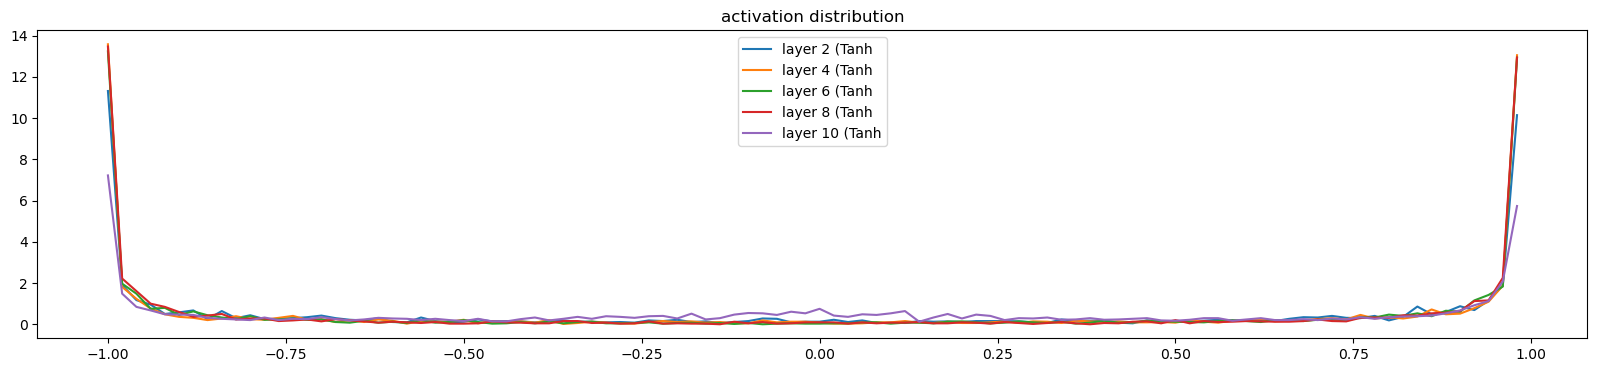

In [17]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000033, std 3.485021e-03
layer 4 (      Tanh): mean +0.000030, std 3.329855e-03
layer 6 (      Tanh): mean -0.000035, std 3.105954e-03
layer 8 (      Tanh): mean +0.000077, std 3.614611e-03
layer 10 (      Tanh): mean -0.000003, std 4.846754e-03


Text(0.5, 1.0, 'gradient distribution')

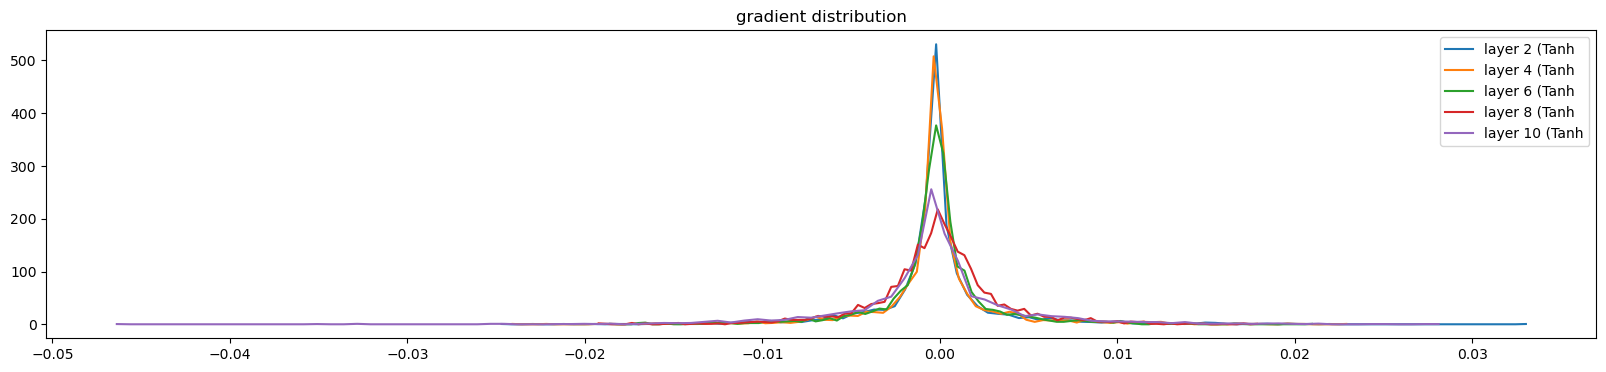

In [18]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000322 | std 1.594213e-02 | grad:data ratio 1.263838e-02
weight  (30, 100) | mean -0.000053 | std 9.775016e-03 | grad:data ratio 2.140835e-02
weight (100, 100) | mean -0.000084 | std 5.785768e-03 | grad:data ratio 2.152671e-02
weight (100, 100) | mean -0.000009 | std 5.710802e-03 | grad:data ratio 2.185234e-02
weight (100, 100) | mean -0.000013 | std 5.472785e-03 | grad:data ratio 2.145556e-02
weight (100, 100) | mean -0.000082 | std 7.148925e-03 | grad:data ratio 3.475929e-02
weight  (100, 27) | mean +0.000000 | std 1.989581e-02 | grad:data ratio 1.038495e-01


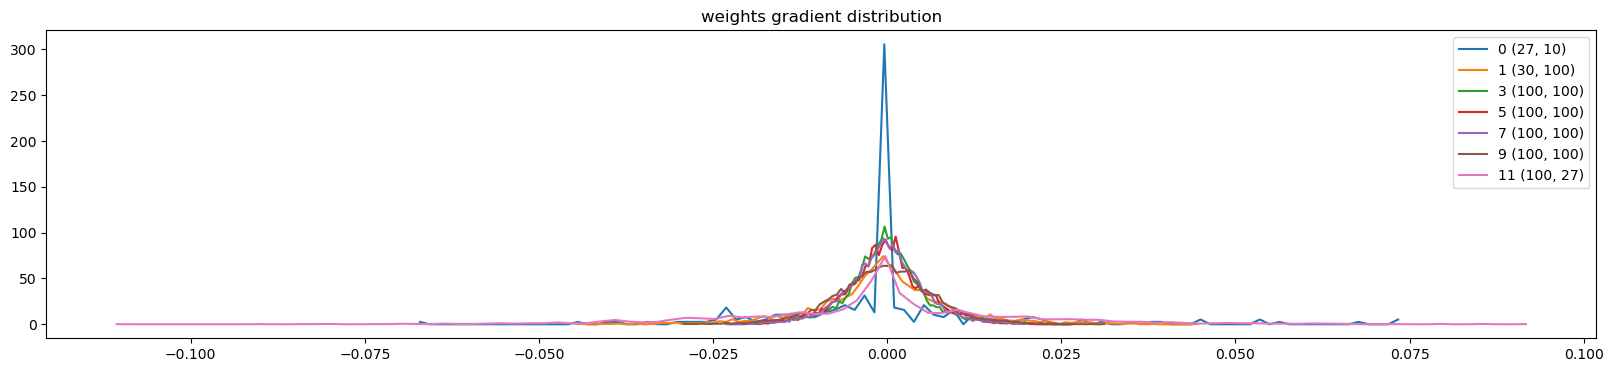

In [19]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

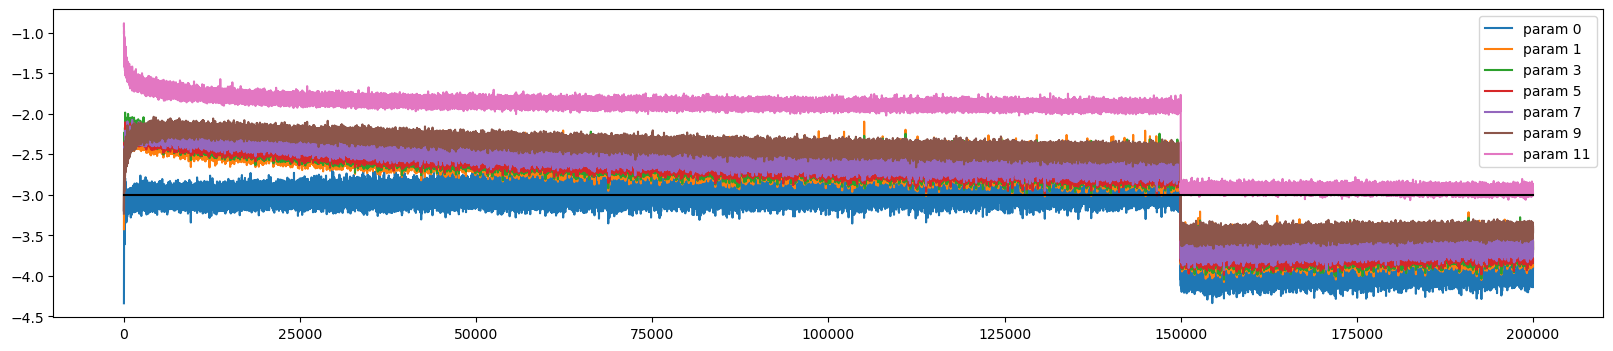

In [20]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([updates[j][i] for j in range(len(updates))])
    legends.append('param %d' % i)
plt.plot([0, len(updates)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [21]:
# after run full optimization

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  # emb = C[x] # (N, block_size, n_embd)
  # x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      x = torch.tensor([context])
      # forward pass the neural net
      # emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      # x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

train 1.9651002883911133
val 2.0875754356384277
carmah.
amelle.
khyim.
shree.
cassanden.
jazhith.
deliah.
jareen.
nellara.
chaiir.
kaleigh.
ham.
jocen.
sin.
zarolle.
liven.
corathonielrixie.
kael.
dusti.
eddeli.


In [22]:
#---------------------------- add batch norm layers ---------------------------------------


n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
print(vocab_size)
print(block_size)

# C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Embedding(vocab_size, n_embd), 
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident for softmax (later) 
  layers[-1].bngain *= 0.1
  # all other layers: apply gain  # these are for deep networks
  for layer in layers[:-1]:  
    if isinstance(layer, Linear):
      layer.weights *= 5/3

parameters = [p for layer in layers for p in layer.parameters()]   # 47024  same when use Embedding instead of C look-up matrix
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

27
3
47024


In [23]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
updates = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  # emb = C[Xb] # embed the characters into vectors
  # x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    Xb = layer(Xb)
  loss = F.cross_entropy(Xb, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())   # llog10 for visualization
  with torch.no_grad():
    updates.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization # for plots below only run 1000

      0/ 200000: 3.2870
  10000/ 200000: 2.3578
  20000/ 200000: 2.1043
  30000/ 200000: 1.9646
  40000/ 200000: 2.2144
  50000/ 200000: 2.2266
  60000/ 200000: 1.7339
  70000/ 200000: 2.1748
  80000/ 200000: 2.1895
  90000/ 200000: 1.8281
 100000/ 200000: 2.3635
 110000/ 200000: 2.2592
 120000/ 200000: 2.0967
 130000/ 200000: 1.8976
 140000/ 200000: 1.8304
 150000/ 200000: 1.9419
 160000/ 200000: 1.8676
 170000/ 200000: 1.8347
 180000/ 200000: 2.2491
 190000/ 200000: 2.0140


layer 3 (      Tanh): mean -0.01, std 0.70, saturated: 16.34%
layer 6 (      Tanh): mean -0.02, std 0.74, saturated: 19.12%
layer 9 (      Tanh): mean -0.00, std 0.77, saturated: 19.03%
layer 12 (      Tanh): mean +0.02, std 0.79, saturated: 20.78%
layer 15 (      Tanh): mean -0.01, std 0.81, saturated: 23.00%


Text(0.5, 1.0, 'activation distribution')

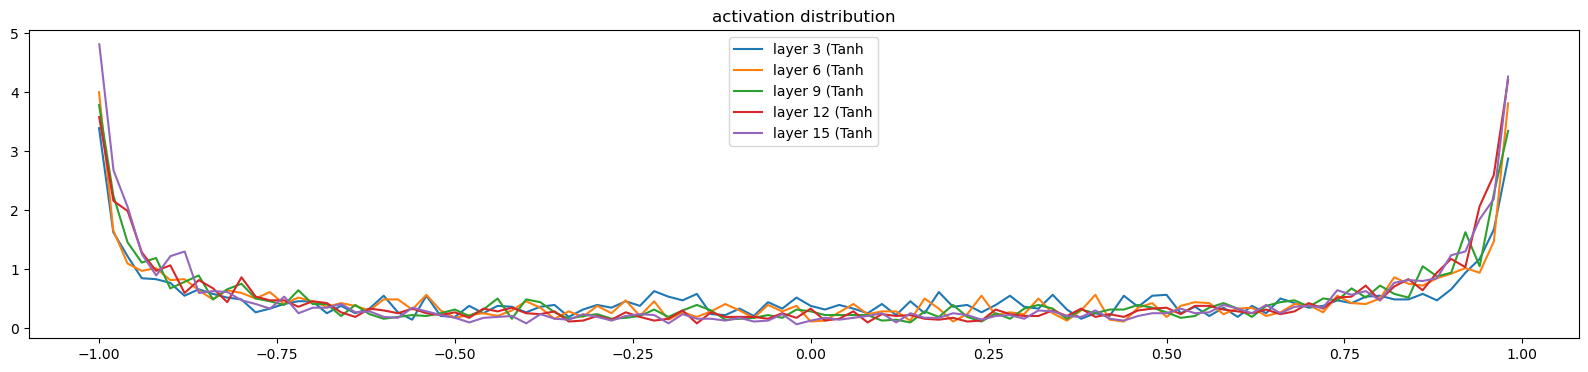

In [24]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 3 (      Tanh): mean -0.000000, std 3.181819e-03
layer 6 (      Tanh): mean +0.000000, std 3.064378e-03
layer 9 (      Tanh): mean -0.000000, std 3.125596e-03
layer 12 (      Tanh): mean -0.000000, std 3.452042e-03
layer 15 (      Tanh): mean +0.000000, std 3.800143e-03


Text(0.5, 1.0, 'gradient distribution')

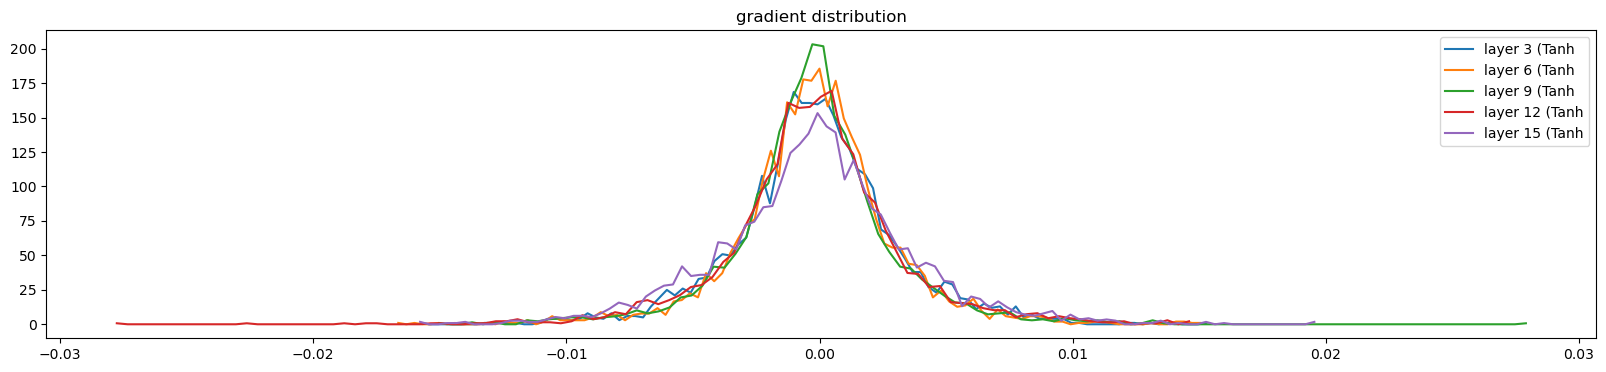

In [25]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.369785e-02 | grad:data ratio 1.194679e-02
weight  (30, 100) | mean +0.000059 | std 6.414189e-03 | grad:data ratio 1.430311e-02
weight   (1, 100) | mean -0.000171 | std 3.599810e-03 | grad:data ratio 2.517537e-02
weight   (1, 100) | mean -0.000002 | std 6.146344e-03 | grad:data ratio 1.671597e-02
weight (100, 100) | mean +0.000059 | std 4.179176e-03 | grad:data ratio 1.533065e-02
weight   (1, 100) | mean -0.000104 | std 3.749663e-03 | grad:data ratio 2.898623e-02
weight   (1, 100) | mean +0.000664 | std 5.718901e-03 | grad:data ratio 1.461842e-02
weight (100, 100) | mean -0.000078 | std 4.398002e-03 | grad:data ratio 1.638218e-02
weight   (1, 100) | mean +0.000054 | std 2.958214e-03 | grad:data ratio 2.185883e-02
weight   (1, 100) | mean +0.000245 | std 6.724402e-03 | grad:data ratio 2.123410e-02
weight (100, 100) | mean +0.000022 | std 4.554049e-03 | grad:data ratio 1.744991e-02
weight   (1, 100) | mean +0.000062 | std 3.196167e-03 | grad:data

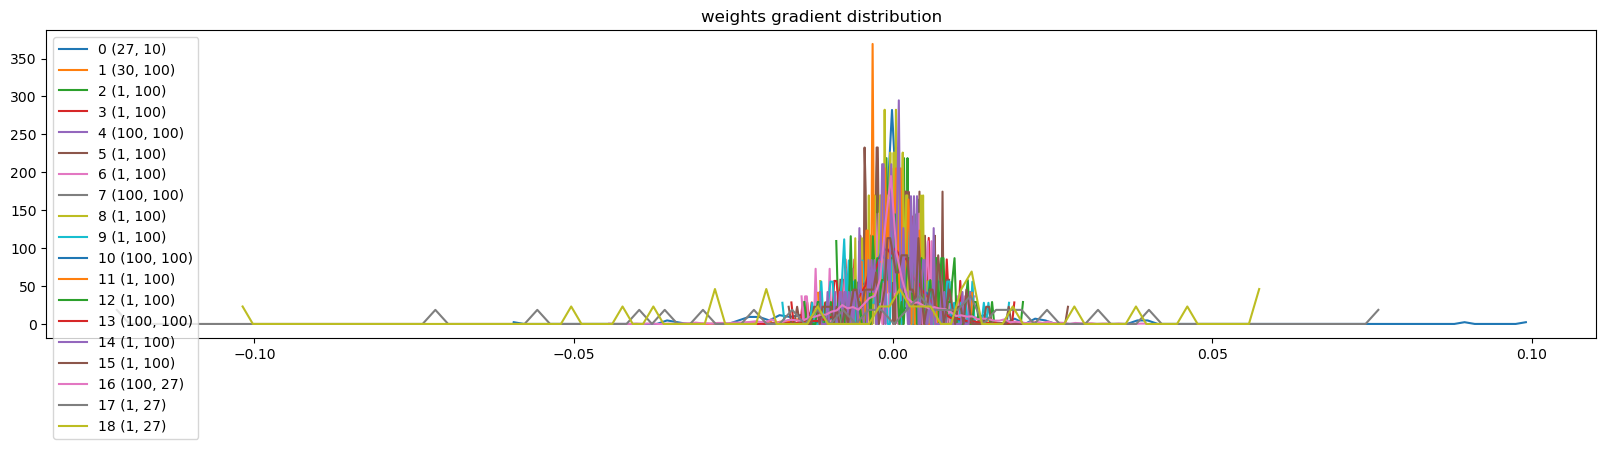

In [26]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

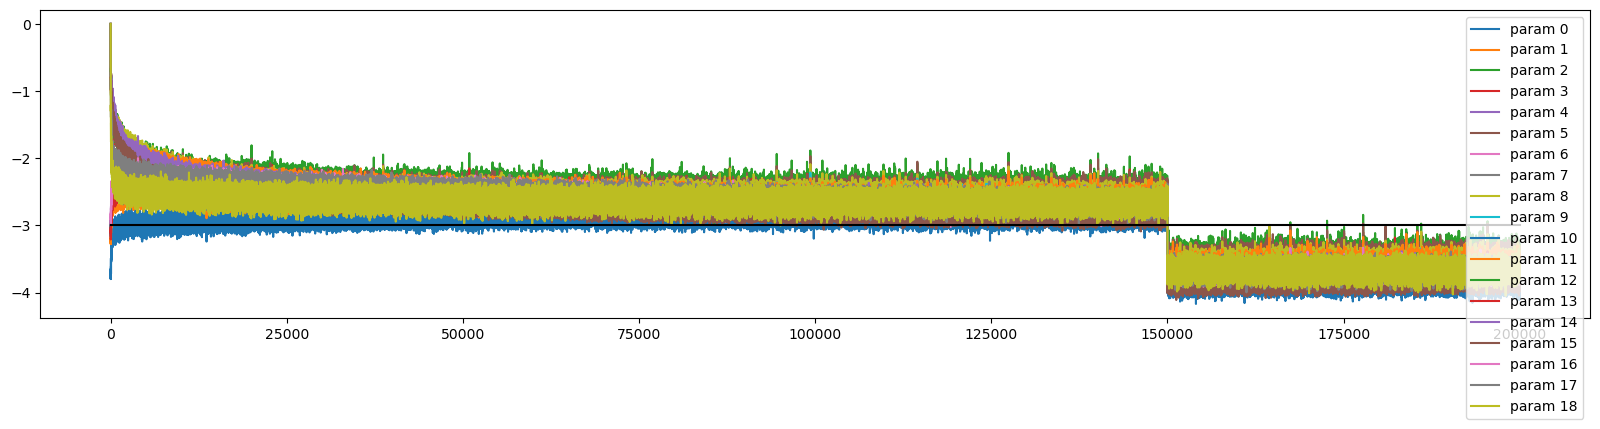

In [27]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([updates[j][i] for j in range(len(updates))])
    legends.append('param %d' % i)
plt.plot([0, len(updates)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [28]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  # emb = C[x] # (N, block_size, n_embd)
  # x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      x = torch.tensor([context])
      # forward pass the neural net
      # emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      # x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

train 2.003933906555176
val 2.080632448196411
carmahfari.
harlin.
mili.
tatyah.
cassie.
rah.
bradheryncia.
qui.
nellara.
chaiivia.
legyn.
ham.
joce.
quintis.
lilah.
jadilyn.
jero.
dearyn.
kai.
eveiluan.
